In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


In [2]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [3]:
raw_df = pd.read_csv('basic_movie_data.csv')
raw_df.sample(5)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget
1009,antbully,http://www.boxofficemojo.com/movies/?id=antbul...,27066,"$28,142,535",Warner Bros.,"July 28, 2006",Animation,1 hrs. 22 min.,PG,$50 million
1035,greathopesprings,http://www.boxofficemojo.com/movies/?id=greath...,23781,"$63,536,011",Sony / Columbia,"August 8, 2012",Comedy / Drama,2 hrs. 1 min.,PG-13,NaN
6351,seaoflove,http://www.boxofficemojo.com/movies/?id=seaofl...,24164,"$58,571,513",Universal,"September 15, 1989",Romantic Thriller,1 hrs. 53 min.,R,NaN
4209,tango,http://www.boxofficemojo.com/movies/?id=tango.htm,19278,"$1,897,948",Sony Classics,"January 22, 1999",Foreign,1 hrs. 45 min.,PG-13,NaN
1006,catchmeifyoucan,http://www.boxofficemojo.com/movies/?id=catchm...,32944,"$164,615,351",DreamWorks,"December 25, 2002",Comedy / Drama,2 hrs. 20 min.,PG-13,$52 million


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 10 columns):
name                    6926 non-null object
url                     6926 non-null object
file_size               6926 non-null int64
domestic_total_gross    6788 non-null object
distributor             6926 non-null object
release_date            6926 non-null object
genre                   6926 non-null object
runtime                 6875 non-null object
mpaa_rating             6926 non-null object
production_budget       2629 non-null object
dtypes: int64(1), object(9)
memory usage: 541.2+ KB


In [5]:
raw_df_subset = raw_df.dropna(subset=['production_budget','domestic_total_gross'])
raw_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 6 to 6923
Data columns (total 10 columns):
name                    2605 non-null object
url                     2605 non-null object
file_size               2605 non-null int64
domestic_total_gross    2605 non-null object
distributor             2605 non-null object
release_date            2605 non-null object
genre                   2605 non-null object
runtime                 2601 non-null object
mpaa_rating             2605 non-null object
production_budget       2605 non-null object
dtypes: int64(1), object(9)
memory usage: 223.9+ KB


In [6]:
import re
import datetime as dt

def parse_date_string(string):
    return dt.datetime.strptime(string, '%B %d, %Y').date()

def parse_runtime_string(string):
    if type(string) != str: return string
    hours, minutes = [float(re.sub(r"[^0-9.]?", "", s)) for s in string.split(' hrs. ')]
    return hours * 60 + minutes

def parse_dollar_string(string):
    if type(string) != str: return string
    unit = 1e6 if 'million' in string else 1
    if ':' in string: string = string.split(':')[0]
    parsed_string = re.sub(r"[^0-9.]?", "", string)
    n = float(parsed_string)
    if n * unit > 1e9:
        print(string)
    return n * unit

In [7]:
df = raw_df_subset.copy()
df['release_date'] = raw_df_subset.release_date.apply(parse_date_string)
df['runtime'] = raw_df_subset.runtime.apply(parse_runtime_string)
df['production_budget'] = raw_df_subset.production_budget.apply(parse_dollar_string)
df['domestic_total_gross'] = raw_df_subset.domestic_total_gross.apply(parse_dollar_string)

In [8]:
df['gross_to_budget_ratio'] = df.domestic_total_gross / df.production_budget
df['gross_minus_budget'] = df.domestic_total_gross - df.production_budget

In [9]:
df.sort_values('gross_to_budget_ratio', ascending=False).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
4348,paranormalactivity,http://www.boxofficemojo.com/movies/?id=parano...,29252,107918810.0,Paramount,2009-09-25,Horror,99.0,R,15000.0,7194.587333,107903810.0
3625,newlinehorror2015,http://www.boxofficemojo.com/movies/?id=newlin...,21824,22764410.0,Warner Bros. (New Line),2015-07-10,Horror,81.0,R,100000.0,227.644100,22664410.0
1933,clerks,http://www.boxofficemojo.com/movies/?id=clerks...,20900,3151130.0,Miramax,1994-10-19,Comedy,92.0,R,27000.0,116.708519,3124130.0
4487,napoleondynamite,http://www.boxofficemojo.com/movies/?id=napole...,26884,44540956.0,Fox Searchlight,2004-06-11,Comedy,86.0,PG,400000.0,111.352390,44140956.0
5224,once,http://www.boxofficemojo.com/movies/?id=once.htm,20173,9439923.0,Fox Searchlight,2007-05-16,Music Drama,85.0,R,150000.0,62.932820,9289923.0
2743,openwater,http://www.boxofficemojo.com/movies/?id=openwa...,25403,30610863.0,Lions Gate,2004-08-06,Horror,79.0,R,500000.0,61.221726,30110863.0
6622,devilinside,http://www.boxofficemojo.com/movies/?id=devili...,26185,53261944.0,Paramount,2012-01-06,Horror,87.0,R,1000000.0,53.261944,52261944.0
5704,saw,http://www.boxofficemojo.com/movies/?id=saw.htm,29483,55185045.0,Lions Gate,2004-10-29,Horror,100.0,R,1200000.0,45.987538,53985045.0
785,snowwhite,http://www.boxofficemojo.com/movies/?id=snowwh...,19405,66596803.0,Disney,1937-12-21,Animation,83.0,G,1499000.0,44.427487,65097803.0
3830,brothersmcmullen,http://www.boxofficemojo.com/movies/?id=brothe...,19597,10426506.0,Fox Searchlight,1995-08-11,Comedy,98.0,R,238000.0,43.808849,10188506.0


In [10]:
df.sort_values('gross_minus_budget', ascending=False).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
6418,starwars7,http://www.boxofficemojo.com/movies/?id=starwa...,53067,936662225.0,Buena Vista,2015-12-18,Sci-Fi Fantasy,136.0,PG-13,245000000.0,3.823111,691662225.0
5720,avatar,http://www.boxofficemojo.com/movies/?id=avatar...,56984,749766139.0,Fox,2009-12-18,Sci-Fi Adventure,160.0,PG-13,237000000.0,3.163570,512766139.0
6635,jurassicpark4,http://www.boxofficemojo.com/movies/?id=jurass...,45119,652270625.0,Universal,2015-06-12,Action / Adventure,124.0,PG-13,150000000.0,4.348471,502270625.0
4193,avengers11,http://www.boxofficemojo.com/movies/?id=avenge...,53870,623357910.0,Buena Vista,2012-05-04,Action / Adventure,142.0,PG-13,220000000.0,2.833445,403357910.0
4665,titanic,http://www.boxofficemojo.com/movies/?id=titani...,44670,600788188.0,Paramount,1997-12-19,Romance,194.0,PG-13,200000000.0,3.003941,400788188.0
1025,et,http://www.boxofficemojo.com/movies/?id=et.htm,37645,359197037.0,Universal,1982-06-11,Family Adventure,117.0,PG,10500000.0,34.209242,348697037.0
3253,darkknight,http://www.boxofficemojo.com/movies/?id=darkkn...,51942,533345358.0,Warner Bros.,2008-07-18,Action / Adventure,150.0,PG-13,185000000.0,2.882948,348345358.0
234,beautyandthebeast2017,http://www.boxofficemojo.com/movies/?id=beauty...,47435,504014165.0,Buena Vista,2017-03-17,Fantasy,129.0,PG,160000000.0,3.150089,344014165.0
435,starwars2016,http://www.boxofficemojo.com/movies/?id=starwa...,43675,532177324.0,Buena Vista,2016-12-16,Sci-Fi Adventure,133.0,PG-13,200000000.0,2.660887,332177324.0
5780,hungergames,http://www.boxofficemojo.com/movies/?id=hunger...,47800,408010692.0,Lionsgate,2012-03-23,Action / Adventure,142.0,PG-13,78000000.0,5.230906,330010692.0


In [11]:
df.sort_values('gross_minus_budget', ascending=True).head(10)

,name,url,file_size,domestic_total_gross,distributor,release_date,genre,runtime,mpaa_rating,production_budget,gross_to_budget_ratio,gross_minus_budget
2719,johncarterofmars,http://www.boxofficemojo.com/movies/?id=johnca...,28942,73078100.0,Buena Vista,2012-03-09,Sci-Fi Adventure,132.0,PG-13,250000000.0,0.292312,-176921900.0
1747,battleship,http://www.boxofficemojo.com/movies/?id=battle...,28976,65422625.0,Universal,2012-05-18,Action,131.0,PG-13,209000000.0,0.313027,-143577375.0
4402,47ronin,http://www.boxofficemojo.com/movies/?id=47roni...,23680,38362475.0,Universal,2013-12-25,Action Drama,127.0,PG-13,175000000.0,0.219214,-136637525.0
409,kingarthur2016,http://www.boxofficemojo.com/movies/?id=kingar...,25600,39175066.0,Warner Bros.,2017-05-12,Adventure,126.0,PG-13,175000000.0,0.223858,-135824934.0
932,jackthegiantkiller,http://www.boxofficemojo.com/movies/?id=jackth...,28465,65187603.0,Warner Bros. (New Line),2013-03-01,Adventure,114.0,PG-13,195000000.0,0.334295,-129812397.0
6840,jupiterascending,http://www.boxofficemojo.com/movies/?id=jupite...,25950,47387723.0,Warner Bros.,2015-02-06,Sci-Fi,127.0,PG-13,176000000.0,0.269248,-128612277.0
4785,marsneedsmoms,http://www.boxofficemojo.com/movies/?id=marsne...,26176,21392758.0,Buena Vista,2011-03-11,Animation,88.0,PG,150000000.0,0.142618,-128607242.0
1112,13thwarrior,http://www.boxofficemojo.com/movies/?id=13thwa...,23539,32698899.0,Buena Vista,1999-08-27,Period Adventure,102.0,R,160000000.0,0.204368,-127301101.0
5283,loneranger,http://www.boxofficemojo.com/movies/?id=lonera...,28762,89302115.0,Buena Vista,2013-07-03,Western,149.0,PG-13,215000000.0,0.415359,-125697885.0
126,alexander,http://www.boxofficemojo.com/movies/?id=alexan...,34731,34297191.0,Warner Bros.,2004-11-24,Historical Epic,176.0,R,155000000.0,0.221272,-120702809.0


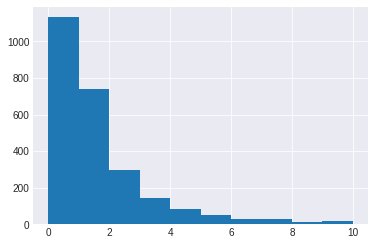

In [12]:
df[df.gross_to_budget_ratio < 10].gross_to_budget_ratio.hist(bins=[0,1,2,3,4,5,6,7,8,9,10]);

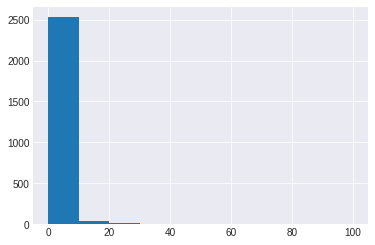

In [13]:
df[df.gross_to_budget_ratio < 100].gross_to_budget_ratio.hist(bins=[0,10,20,30,40,50,60,70,80,90,100]);

In [16]:
less_than_1 = len(df[df.gross_to_budget_ratio < 1]) / len(df)
less_than_2 = len(df[df.gross_to_budget_ratio < 2]) / len(df)
less_than_10 = len(df[df.gross_to_budget_ratio < 10]) / len(df)
(less_than_1, (less_than_2 - less_than_1), (less_than_10 - less_than_2), (1 - less_than_10))

(0.4345489443378119,
 0.28291746641074855,
 0.253358925143954,
 0.029174664107485593)

In [15]:
df.gross_to_budget_ratio.median()

1.1673481388888889

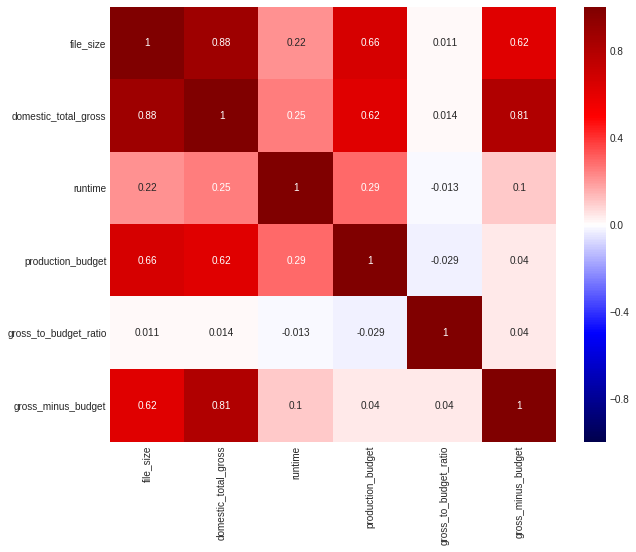

In [20]:
feature_columns = ['file_size','domestic_total_gross','release_date','runtime',
                   'production_budget','gross_to_budget_ratio','gross_minus_budget']
features = df[feature_columns]
plt.figure(figsize=(10,8))
sns.heatmap(features.corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);

In [29]:
median_budget = df.production_budget.median()
print(median_budget)
avg_ratio_for_big_budget = df[df.production_budget > median_budget].gross_to_budget_ratio.mean()
avg_ratio_for_small_budget = df[df.production_budget < median_budget].gross_to_budget_ratio.mean()
# Small budget films have greater ROI
(avg_ratio_for_small_budget, avg_ratio_for_big_budget)

35000000.0


(9.26685410943, 1.2011132609548412)

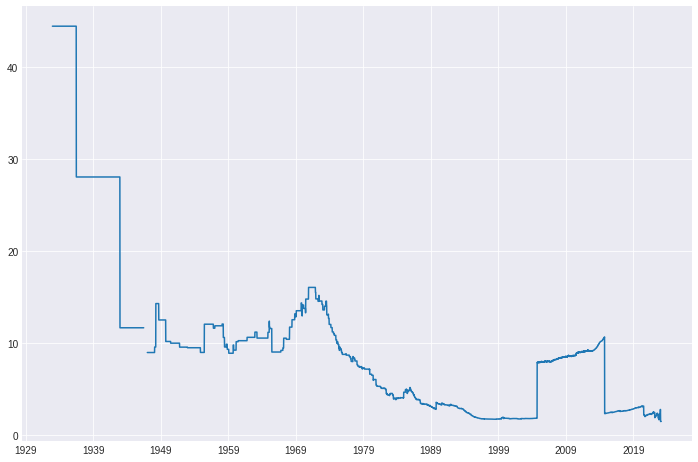

In [37]:
dates = []
rolling_avg_ratios = []
start_date = df.release_date.min()
end_date = df.release_date.max()
days_between = (end_date - start_date).days
for day in range(days_between):
    start_date += dt.timedelta(days=1)
    end_date = start_date + dt.timedelta(days=365*10)
    avg_ratio = df[(df.release_date >= start_date) & (df.release_date < end_date)].gross_to_budget_ratio.mean()
    dates.append(start_date + dt.timedelta(days=365*5))
    rolling_avg_ratios.append(avg_ratio)
plt.figure(figsize=(12,8))
plt.plot(dates, rolling_avg_ratios);

In [ ]:
linear_model = pm.Model()

with linear_model:
    beta = pm.Normal('beta', mu=1, sd=1000, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1000)
    mu = beta[0] + beta[1]*df.production_budget
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=df.gross_to_budget_ratio)
    trace = pm.sample(20000)
    pm.traceplot(trace);
    

In [ ]:
pd.Series(trace['sim_file_size']).sample(len(df.file_size)).hist()
df.file_size.hist(alpha=0.5);

In [ ]:
pm.find_MAP(model=file_size_model)